In [2]:
import uproot as ur
import awkward as ak
import numpy as np

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "7"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [4]:
import tensorflow as tf

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN

from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

2021-10-19 07:19:47.288973: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


# DEFAULT OLD INPUT

## Read dataset trees for pi0 and pipm

Inputs consists of two components:
- `X` : has X_pipm first and then X_pi0. It has shape `(num_clusters,max_num_cells,4)`  The cells are given as `(log(E),eta,phi,samplerID)` values
- `Y` : a numpy array of quark/gluon jet labels (pipm=`1` and pi0=`0`). 

In [5]:
# my worspace and directories
path_prefix = '/home/dportill/LCStudies/'
plotpath = path_prefix+'classifier/Plots_EFN/'
modelpath = path_prefix+'classifier/Models_EFN/'

data_path = '/fast_scratch/atlas_images/v01-45/'

In [6]:
X = np.load(data_path+'X_4.npy')

In [8]:
Y = tf.keras.utils.to_categorical(np.concatenate((np.ones(90000), np.zeros(90000))))

## PFN parameters

In [7]:
from energyflow.utils import data_split

# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=10000, test=40000)

In [9]:
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)

In [17]:
pfn_X_4 = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_7 (Activation)       (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_7[0][0]               
____________________________________________________________________________________________

In [18]:
# train model
history_X_4 = pfn_X_4.fit(X_train, Y_train,
        epochs=100,
        batch_size=500,
        validation_data=(X_val, Y_val),
        verbose=1)

Epoch 1/100
260/260 [==============================] - 58s 219ms/step - loss: 5.8582 - acc: 0.7094 - val_loss: 2.3175 - val_acc: 0.7390
Epoch 2/100
260/260 [==============================] - 16s 60ms/step - loss: 1.1531 - acc: 0.7413 - val_loss: 0.5526 - val_acc: 0.7458
Epoch 3/100
260/260 [==============================] - 14s 55ms/step - loss: 0.6353 - acc: 0.7468 - val_loss: 0.4139 - val_acc: 0.7945
Epoch 4/100
260/260 [==============================] - 14s 56ms/step - loss: 0.4137 - acc: 0.7867 - val_loss: 0.4287 - val_acc: 0.7985
Epoch 5/100
260/260 [==============================] - 15s 59ms/step - loss: 0.5923 - acc: 0.7597 - val_loss: 0.4100 - val_acc: 0.7955
Epoch 6/100
260/260 [==============================] - 15s 57ms/step - loss: 0.4110 - acc: 0.7869 - val_loss: 0.4035 - val_acc: 0.7996
Epoch 7/100
260/260 [==============================] - 15s 56ms/step - loss: 0.4088 - acc: 0.7958 - val_loss: 0.3898 - val_acc: 0.8033
Epoch 8/100
260/260 [==============================] -

In [19]:
pfn_X_4.save(modelpath+'pfn_X_4_defaultInput.h5')

In [21]:
# get area under the ROC curve
preds_X_4 = pfn_X_4.predict(X_test, batch_size=1000)
auc_X_4 = roc_auc_score(Y_test[:,1], preds_X_4[:,1])
print('AUC:', auc_X_4)

AUC: 0.9773549509707842


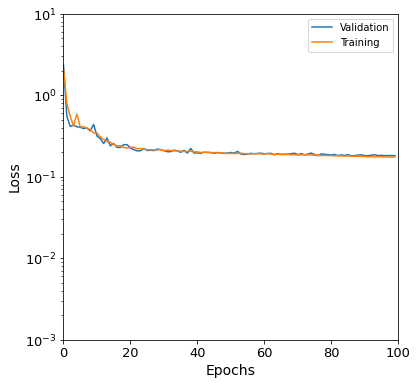

In [22]:
# 40 files with netOpt2
M = len(history_X_4.history['val_loss'])
fig = plt.figure(figsize=(6,6))
plt.plot(history_X_4.history['val_loss'], label="Validation")
plt.plot(history_X_4.history['loss'], label="Training")
plt.yscale('log')
plt.ylim(.001,10)
plt.yticks(fontsize=13)
plt.xlim(0,M)
plt.xticks(fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', ncol=1)
# plt.tight_layout()
#plt.savefig('./.png', format='png')
plt.show()

# DEFAULT OLD INPUT with TF.DATASETS

In [10]:
X.shape

(180000, 2000, 4)

In [12]:
deepSets = tf.data.Dataset.from_tensor_slices((X, Y))

2021-10-19 08:21:42.207559: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-19 08:21:42.336366: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-19 08:21:42.499778: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1746] Found device 0 with properties: 
pciBusID: 0000:b2:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-10-19 08:21:42.502953: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-19 08:21:42.594448: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-19 08:21:42.594576: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.

In [13]:
deepSets


<TensorSliceDataset shapes: ((2000, 4), (2,)), types: (tf.float64, tf.float32)>

In [14]:
Total = deepSets.cardinality().numpy()
print("Total Number of  CLUSTERS (point clouds?): ", Total)

Total Number of  CLUSTERS (point clouds?):  180000


In [15]:
val= int(Total*0.15)
test= int(Total*0.15)
train=Total-test-val

In [16]:
print("train:", train)
print("test:" ,test)
print("val:" ,val)

train: 126000
test: 27000
val: 27000


In [17]:
##val=10000, test=40000

In [18]:
ds_train = deepSets.skip(val+test)

In [19]:
ds_test = deepSets.take(test+val)
ds_val = ds_test.skip(test)
ds_test = ds_test.take(test)

In [20]:
print(ds_train.cardinality())
print(ds_val.cardinality())
print(ds_test.cardinality())

tf.Tensor(126000, shape=(), dtype=int64)
tf.Tensor(27000, shape=(), dtype=int64)
tf.Tensor(27000, shape=(), dtype=int64)


## Determine number of batches

In [21]:
print("len X ", len(X))
print("len Y ", len(Y))

len X  180000
len Y  180000


In [22]:
batch_size = 1000 

Nevts = len(X)
Nbatches = int(np.floor(Nevts/batch_size))
print(Nbatches)


180


In [23]:
ds_train = ds_train.batch(Nbatches, drop_remainder=True)
ds_val = ds_val.batch(Nbatches, drop_remainder=True)
ds_test = ds_test.batch(Nbatches, drop_remainder=True)

## PFN parameters

In [26]:
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)

In [27]:
pfn_X_4_tfd = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation[0][0]                 
______________________________________________________________________________________________

In [29]:
history2 = pfn_X_4_tfd.fit(ds_train,
        epochs=100,
        validation_data=ds_val,
        verbose=1)

Epoch 1/100
700/700 [==============================] - 55s 75ms/step - loss: 18.1162 - acc: 0.9768 - val_loss: 578.9963 - val_acc: 0.0000e+00
Epoch 2/100
700/700 [==============================] - 53s 74ms/step - loss: 34.7860 - acc: 0.9705 - val_loss: 718.0536 - val_acc: 0.0000e+00
Epoch 3/100
700/700 [==============================] - 55s 75ms/step - loss: 3.6447 - acc: 0.9801 - val_loss: 1152.3438 - val_acc: 2.2222e-04
Epoch 4/100
700/700 [==============================] - 50s 71ms/step - loss: 5.2503 - acc: 0.9798 - val_loss: 189.4378 - val_acc: 0.0017
Epoch 5/100
700/700 [==============================] - 53s 73ms/step - loss: 0.9364 - acc: 0.9851 - val_loss: 86.1987 - val_acc: 0.0031
Epoch 6/100
700/700 [==============================] - 55s 75ms/step - loss: 1.1486 - acc: 0.9813 - val_loss: 95.3430 - val_acc: 0.0026
Epoch 7/100
700/700 [==============================] - 51s 72ms/step - loss: 1.1876 - acc: 0.9816 - val_loss: 29.2191 - val_acc: 6.2963e-04
Epoch 8/100
700/700 [====

In [33]:
pfn_X_4_tfd.save(modelpath+'pfn_X_4_tfd_defaultInput.h5')

In [ ]:
# get area under the ROC curve
#preds_X_4_tfd = pfn_X_4_tfd.predict(X_test, batch_size=1000)
#auc_X_4_tfd = roc_auc_score(Y_test[:,1], preds_X_4[:,1])
#print('AUC:', auc_X_4)

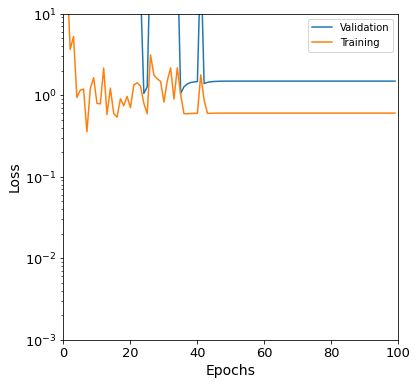

In [32]:
# 40 files with netOpt2
M = len(history2.history['val_loss'])
fig = plt.figure(figsize=(6,6))
plt.plot(history2.history['val_loss'], label="Validation")
plt.plot(history2.history['loss'], label="Training")
plt.yscale('log')
plt.ylim(.001,10)
plt.yticks(fontsize=13)
plt.xlim(0,M)
plt.xticks(fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', ncol=1)
# plt.tight_layout()
#plt.savefig('./.png', format='png')
plt.show()